In [51]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

### Goals

1. Use HRTF to apply various sound directions (front, left, right, back, top, bottom, and the in-betweens)
2. Use advanced track separation algorithms to separate all the instruments  
ㄴ Moises DB + HT-demucs로 직접 훈련 할때까지는 힘들겠는데...?
3. Use head-tracking to control audio sources in real time (preferably, using the web interface)
4. 3D background (visual) is shown

### Spatial Audio

Install Slab (pronounced like S-lab)

In [2]:
# !py -3.11 -m pip install slab

In [3]:
import slab # this library is simply fucking awesome

In [4]:
hrtf = slab.HRTF.kemar()

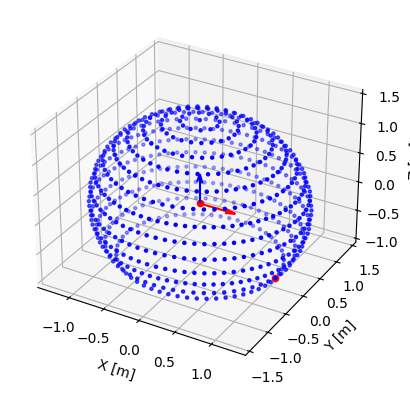

In [5]:
hrtf = slab.HRTF.kemar()
sourceidx = hrtf.cone_sources(0) + hrtf.elevation_sources(0)
hrtf.plot_sources(0) # plot the sources in 3D, highlighting the selected sources

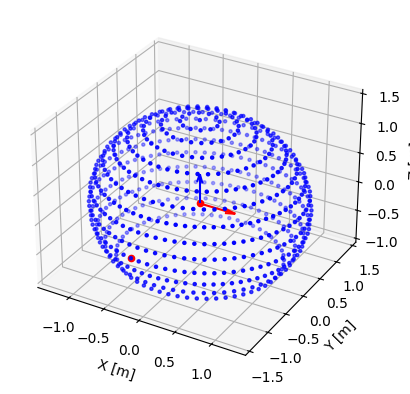

In [6]:
hrtf.plot_sources(240)

In [73]:
coordinates = hrtf.sources.cartesian

In [80]:
coordinates

array([[ 1.072  ,  0.     , -0.9    ],
       [ 1.065  ,  0.12006, -0.9    ],
       [ 1.046  ,  0.2386 , -0.9    ],
       ...,
       [ 0.1216 , -0.2106 ,  1.379  ],
       [ 0.2106 , -0.1216 ,  1.379  ],
       [ 0.     ,  0.     ,  1.4    ]], dtype=float16)

In [81]:
norm(hrtf.sources[0][0]/1.399)

1.0

In [91]:
direction = np.array([[0.0, -1.0, 0.0]])
kemar_hrtf = hrtf

In [92]:
coords = kemar_hrtf.sources[0]/1.399
cos_sim = dot(direction, coords.T)/(norm(direction)*norm(coords))

# p1 = direction[:,-1].dot(coords[:,:])
# p2 = norm(direction[:,:-1],axis=0)*norm(coords[:,-1])
# out1 = p1/p2

# cos_sim = out1

idx = cos_sim.argmax()

In [93]:
vocals_dir = hrtf.apply(idx, vocals)
vocals_dir.play()

In [68]:
idx

260

In [ ]:
def direction_to_kemar_source(direction, kemar_hrtf):
    coords = kemar_hrtf.sources[0]/1.399
    cos_sim = dot(direction, coords)/(norm(direction)*norm(coords))
    idx = cos_sim.argmax()

In [7]:
hrtf.sources[0].shape

(710, 3)

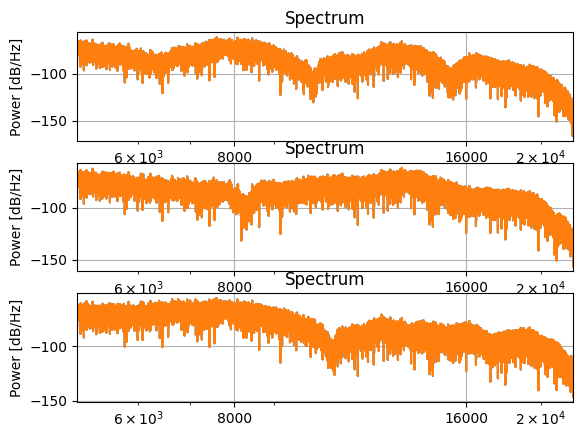

In [8]:
sound = slab.Sound.pinknoise(samplerate=hrtf.samplerate)  # the sound to be spatialized
fig, ax = plt.subplots(3)
sourceidx = [0, 260, 536]  # sources at elevations -40, 0 and 40
spatial_sounds = []
for i, index in enumerate(sourceidx):
    spatial_sounds.append(hrtf.apply(index, sound))
    spatial_sounds[i].spectrum(axis=ax[i], low_cutoff=5000, show=False)
plt.show()

In [9]:
# tone = slab.Sound.tone(frequency=500, duration=0.5)
# tone.level = 80 # setting the intensity to 80 dB
# tone.play()
noise = slab.Sound.pinknoise(duration=0.5)
noise.filter(frequency=(250, 1000), kind='bp') # bandpass .25 to 1 kHz
noise.level = 70 # 10 dB lower than the tone
noise.play()
# stimulus = tone + noise # combine the two signals
# stimulus = stimulus.ramp() # apply on- and offset ramps to avoid clicks
# stimulus.play()

In [10]:
spatial_sounds[0].play()

In [79]:
song_name = "Imagine Dragons - Warriors"
# song_name = "Detective Conan - Hello Mr. My Yesterday 10기 오프닝(OP)"
# song_name = "Jacob Collier - Moon River"
bass = slab.Sound.read(f"./separated/htdemucs/{song_name}/bass.wav")
drums = slab.Sound.read(f"./separated/htdemucs/{song_name}/drums.wav")
other = slab.Sound.read(f"./separated/htdemucs/{song_name}/other.wav")
vocals = slab.Sound.read(f"./separated/htdemucs/{song_name}/vocals.wav")

In [12]:
vocals_left = hrtf.apply(208, vocals)

In [13]:
vocals_left.play() # holy shit oh my god LMAO

KeyboardInterrupt: 

In [ ]:
vocals_right = hrtf.apply(240, vocals)

In [14]:
vocals_left_other_right = hrtf.apply(208, vocals) + hrtf.apply(240, other)

In [15]:
vocals_left_other_right.play()

KeyboardInterrupt: 

In [16]:
vocals_left_other_right_drum_top_bass_low = hrtf.apply(208, vocals) + hrtf.apply(240, other) + hrtf.apply(709, drums) + hrtf.apply(0, bass)

In [17]:
vocals_left_other_right_drum_top_bass_low.play()

KeyboardInterrupt: 

In [ ]:
other.play()

KeyboardInterrupt: 

### Music Separation

Install demucs

In [ ]:
# !py -3.11 -m pip install -U git+https://github.com/facebookresearch/demucs#egg=demucs

In [71]:
!demucs "../music-library/Jacob Collier - Moon River.mp3"

Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /Users/yunhocho/Documents/GitHub/musical-intelligence/separated/htdemucs
Separating track ../music-library/Jacob Collier - Moon River.mp3
100%|██████████████████████████████████████████████████████████████████████| 532.35/532.35 [05:15<00:00,  1.69seconds/s]


### Simplest Possible Architecture

1. Let user choose the (vector) location (= direction) of tracks! (Later, make it draggable!)
2. While waiting for head-tracking info: 
3. Get relative vector from head to each source
4. Determine a small sample window (50ms? 100ms?)
5. Apply HRTF to each track according to vector
6. Sum channels & play!
7. Render visuals too. (have little circular icons for each instrument, I guess)

All I need to do is simple location tracking, so let's just do it myself. 

Keep track of 3D locations (i.e., my **view vector**), I guess the field of view (maybe this part is in Pano -> Plane Image logic), where the sources are in 2D plane space, then just draw them onto screen. Simple enough!

Or, lowkey - rendering part might be easier in Threlte/Three+Vue. 흠 어떡할까!?

Let's make a demo video! Post in portfolio!